# Crypto Currency Cross-Prediction

## 2024-01-01 ~ 2024-10-31

In [1]:
from datetime import datetime
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from util import *
from nbeat import *

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# Define the date range
start_date = datetime(2023, 1, 1)  # Start date in milliseconds
end_date = datetime(2023, 11, 1)    # End date in milliseconds (exclusive)

In [4]:
# Fetch historical data
bnb_data = fetchHistoricalData('BNBUSDT', start_date, end_date)

if bnb_data is not None:
    print(bnb_data)

     Open Time   Open   High    Low  Close           Volume
0   2023-01-01  246.3  246.7  243.4  244.4  109450.11700000
1   2023-01-02  244.5  247.9  240.7  245.2  173452.90000000
2   2023-01-03  245.3  247.0  244.4  246.1  115059.99100000
3   2023-01-04  246.2  261.0  245.6  258.9  370055.08200000
4   2023-01-05  258.9  259.2  255.2  256.7  145297.96300000
..         ...    ...    ...    ...    ...              ...
299 2023-10-27  223.2  231.6  219.9  224.1  970917.48900000
300 2023-10-28  224.2  228.4  224.1  225.7  347691.43700000
301 2023-10-29  225.7  228.1  223.6  227.1  269033.79600000
302 2023-10-30  227.1  229.2  224.6  228.0  397120.27600000
303 2023-10-31  228.0  229.3  223.9  226.2  465273.26800000

[304 rows x 6 columns]


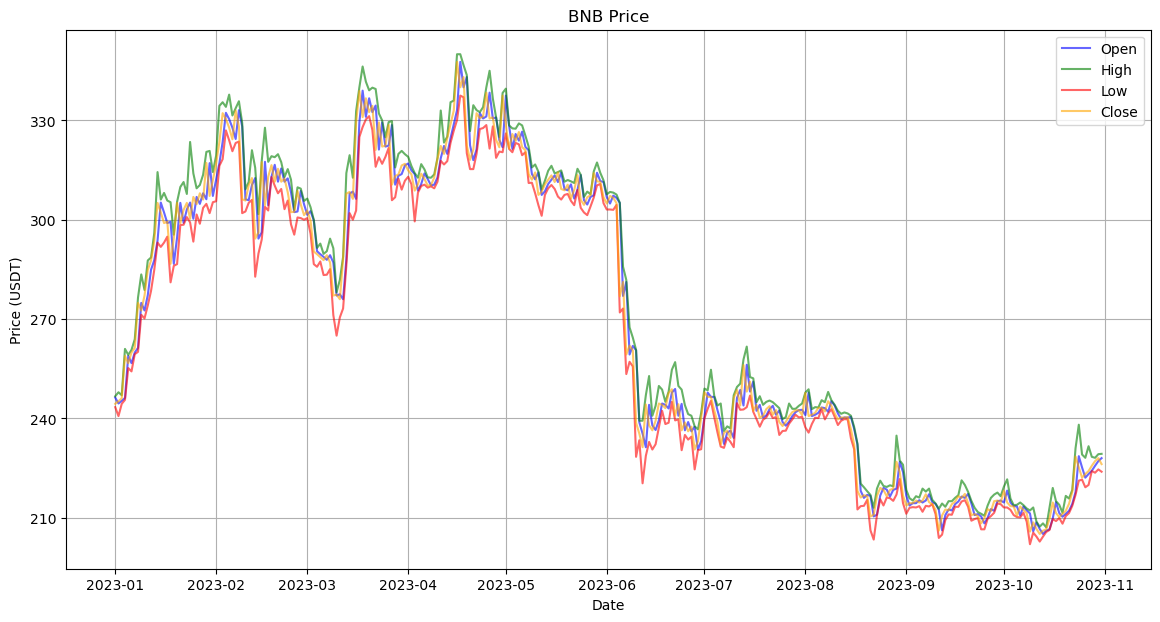

In [5]:
plotPriceDatas(bnb_data, 'BNB Price')

In [6]:
# Fetch historical data
btc_data = fetchHistoricalData('BTCUSDT', start_date, end_date)

     Open Time      Open      High       Low     Close           Volume
0   2023-01-01  16541.77  16628.00  16499.01  16616.75   96925.41374000
1   2023-01-02  16617.17  16799.23  16548.70  16672.87  121888.57191000
2   2023-01-03  16672.78  16778.40  16605.28  16675.18  159541.53733000
3   2023-01-04  16675.65  16991.87  16652.66  16850.36  220362.18862000
4   2023-01-05  16850.36  16879.82  16753.00  16831.85  163473.56641000
..         ...       ...       ...       ...       ...              ...
299 2023-10-27  34151.66  34245.00  33390.95  33892.02   32330.40106000
300 2023-10-28  33892.01  34493.33  33860.00  34081.00   16880.13144000
301 2023-10-29  34081.01  34750.11  33930.00  34525.89   20685.52176000
302 2023-10-30  34525.88  34856.00  34062.84  34474.73   33657.95976000
303 2023-10-31  34474.74  34720.49  34025.00  34639.77   32737.89822000

[304 rows x 6 columns]


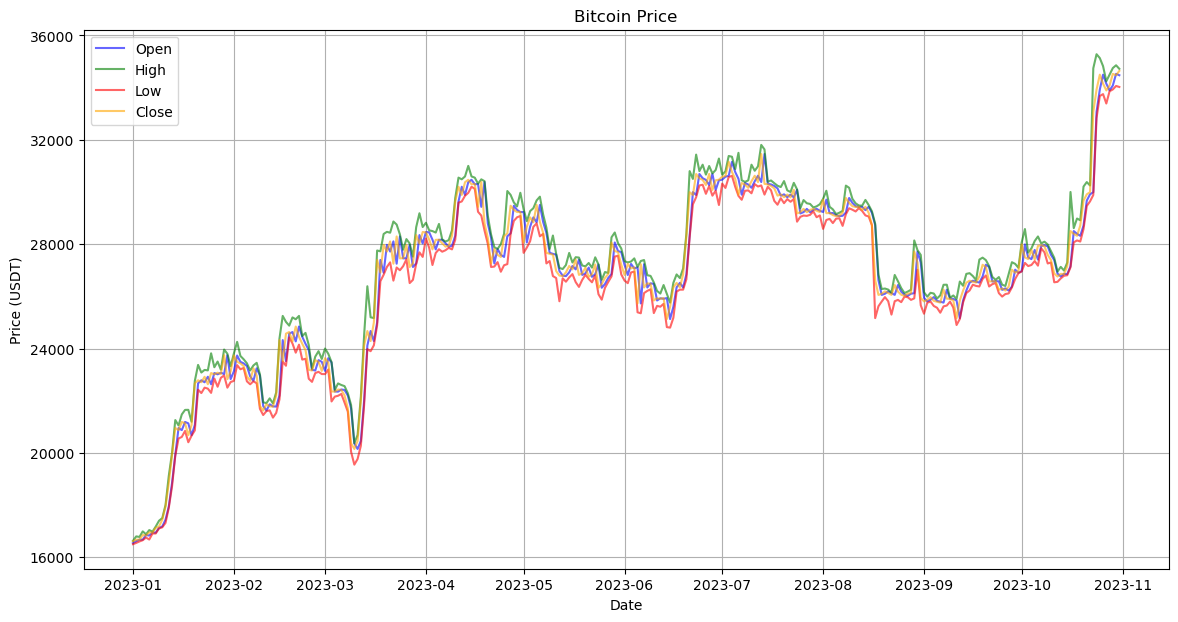

In [7]:
if btc_data is not None:
    print(btc_data)

plotPriceDatas(btc_data, 'Bitcoin Price')

In [8]:
dataSize = len(btc_data)
assert(dataSize == len(bnb_data))
windowSize = 7
testSize = round(dataSize * 0.3)
print(f"dataSize: {dataSize}")
print(f"windowSize: {windowSize}")
print(f"testSize: {testSize}")

dataSize: 304
windowSize: 7
testSize: 91


In [9]:
testingOutput = prepareTestingOutputs(bnb_data["Close"], testSize)
print(testingOutput)

[240.7 241.1 241.7 243.2 243.2 242.1 245.2 243.8 241.5 239.7 240.3 240.2
 240.4 236.7 232.  218.1 216.1 216.8 216.5 210.4 210.9 216.6 219.  218.4
 216.5 218.4 218.8 226.9 223.8 216.7 213.7 214.4 214.4 215.2 214.6 215.2
 217.1 214.7 214.1 212.4 206.1 210.7 212.5 212.2 214.1 214.9 216.5 216.
 217.2 214.4 210.8 211.1 210.5 208.3 209.9 212.6 212.  215.  215.2 214.6
 218.2 214.6 213.5 213.4 210.6 213.4 212.3 211.4 205.8 208.6 206.6 205.1
 206.1 206.5 209.7 214.6 211.4 210.2 211.2 212.1 214.2 217.8 228.5 225.2
 222.1 223.2 224.1 225.7 227.1 228.  226.2]


### Brenchmarking with "trivial prediction"

Trivial prediction is a simple model that predict the next date value as the current one.

[247.7 240.7 241.1 241.7 243.2 243.2 242.1 245.2 243.8 241.5 239.7 240.3
 240.2 240.4 236.7 232.  218.1 216.1 216.8 216.5 210.4 210.9 216.6 219.
 218.4 216.5 218.4 218.8 226.9 223.8 216.7 213.7 214.4 214.4 215.2 214.6
 215.2 217.1 214.7 214.1 212.4 206.1 210.7 212.5 212.2 214.1 214.9 216.5
 216.  217.2 214.4 210.8 211.1 210.5 208.3 209.9 212.6 212.  215.  215.2
 214.6 218.2 214.6 213.5 213.4 210.6 213.4 212.3 211.4 205.8 208.6 206.6
 205.1 206.1 206.5 209.7 214.6 211.4 210.2 211.2 212.1 214.2 217.8 228.5
 225.2 222.1 223.2 224.1 225.7 227.1 228. ]
RootMeanSquaredError 3.2482104301452637


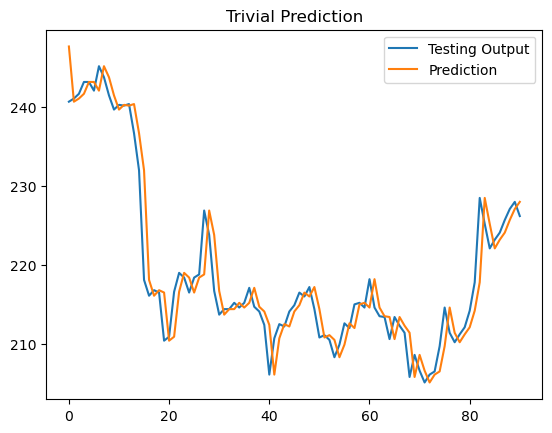

In [10]:
prediction0 = np.array(bnb_data["Close"][range(dataSize - testSize - 1, dataSize - 1)])
print(prediction0)
plt.plot(testingOutput, label="Testing Output")
plt.plot(prediction0, label="Prediction")
plt.title("Trivial Prediction")
plt.legend()

rmse0 = tf.keras.metrics.RootMeanSquaredError()(testingOutput, prediction0)
print(f"RootMeanSquaredError {rmse0}")

### N-Beat Alogrithm
#### [Model1] BNB closing price -> BNB closing price

In [11]:
x_train = prepareTrainingInputs(bnb_data["Close"], windowSize, testSize)
y_train = prepareTraingingOutputs(bnb_data["Close"], windowSize, testSize)
x_test = prepareTestingInputs(bnb_data["Close"], windowSize, testSize)
y_test = prepareTestingOutputs(bnb_data["Close"], testSize)

In [12]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)
test_features_dataset = tf.data.Dataset.from_tensor_slices(x_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
train_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [13]:
nbeatNeuronCount = 512
nBeatLayerCount = 4
nBeatStackCount = 30

# Create input to stacks
input = layers.Input(shape=(windowSize), name="stack_input")
x = input
x = buildNBeatLayers(windowSize, windowSize+1, 1, nbeatNeuronCount, nBeatLayerCount, nBeatStackCount, x)

model1 = tf.keras.Model(inputs=input, outputs=x)
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 stack_input (InputLayer)       [(None, 7)]          0           []                               
                                                                                                  
 InitialBlock (NBeatsBlock)     ((None, 7),          796168      ['stack_input[0][0]']            
                                 (None, 1))                                                       
                                                                                                  
 nbeat_subtract_00 (Subtract)   (None, 7)            0           ['stack_input[0][0]',            
                                                                  'InitialBlock[0][0]']           
                                                                                              

In [14]:
model1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

In [15]:
history1 = model1.fit(train_dataset,
            epochs=5000, # just a large number
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 139: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 317: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 417: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.


RMSE: 3.49
epoch: 417
3/3 [==============================] - 0s 39ms/step - loss: 2.4050 - mae: 2.4050 - mse: 12.1468
rmse1: 3.485222409784848


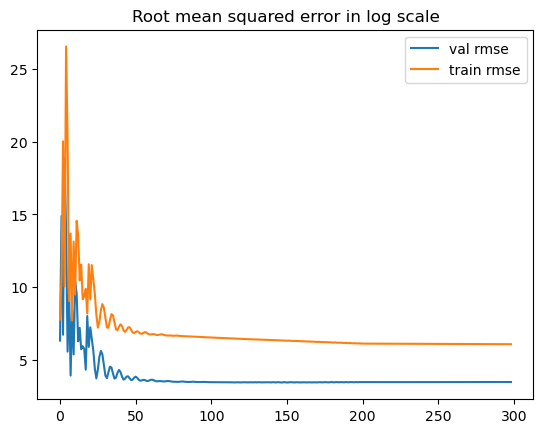

In [48]:
plotHistoryRSME(history1, 300)

rmse1 = np.sqrt(model1.evaluate(x_test, y_test)[2])
print(f"rmse1: {rmse1}")

In [17]:
model1.save('models/model1')

INFO:tensorflow:Assets written to: models/model1\assets


INFO:tensorflow:Assets written to: models/model1\assets


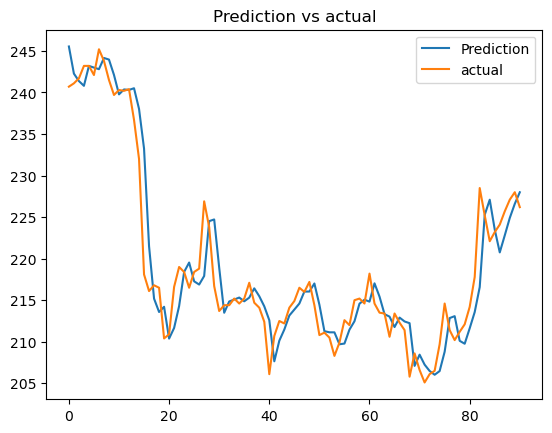

In [18]:
# plot prediction
prediction1 = model1.predict(x_test)
plt.plot(prediction1, label='Prediction')
plt.plot(y_test, label='actual')
plt.title('Prediction vs actual')
plt.legend()

#### [Model2] BNB+BTC closing price -> BNB closing price
##### Appending BTC data after BNB data as input

In [19]:
# x_train = prepareTrainingInputs(bnb_data["Close"], windowSize, testSize)
x_train_btc = prepareTrainingInputs(btc_data["Close"], windowSize, testSize)
x_train2 = [np.concatenate((x_train[i], x_train_btc[i])) for i in range(len(x_train))]
# y_train = prepareTraingingOutputs(bnb_data["Close"], windowSize, testSize)

# x_test = prepareTestingInputs(bnb_data["Close"], windowSize, testSize)
y_test_btc = prepareTestingInputs(btc_data["Close"], windowSize, testSize)
x_test2 = [np.concatenate((x_test[i], y_test_btc[i])) for i in range(len(x_test))]
# y_test = prepareTestingOutputs(bnb_data["Close"], testSize)

train_features_dataset = tf.data.Dataset.from_tensor_slices(x_train2)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)
test_features_dataset = tf.data.Dataset.from_tensor_slices(x_test2)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
train_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 14), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 14), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [20]:
nbeatNeuronCount = 512
nBeatLayerCount = 4
nBeatStackCount = 30

# Create input to stacks
input = layers.Input(shape=(windowSize*2), name="stack_input")
x = input
x = buildNBeatLayers(windowSize*2, windowSize*2+1, 1, nbeatNeuronCount, nBeatLayerCount, nBeatStackCount, x)

model2 = tf.keras.Model(inputs=input, outputs=x)
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 stack_input (InputLayer)       [(None, 14)]         0           []                               
                                                                                                  
 InitialBlock (NBeatsBlock)     ((None, 14),         803343      ['stack_input[0][0]']            
                                 (None, 1))                                                       
                                                                                                  
 nbeat_subtract_00 (Subtract)   (None, 14)           0           ['stack_input[0][0]',            
                                                                  'InitialBlock[0][0]']           
                                                                                            

In [21]:
model2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

In [22]:
history2 = model2.fit(train_dataset,
            epochs=5000, # just a large number
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 201: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 415: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 515: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.


3/3 [==============================] - 2s 41ms/step - loss: 27.9493 - mae: 27.9493 - mse: 1988.3999
rmse2: 44.59147791163408
RMSE: 55.93
epoch: 515


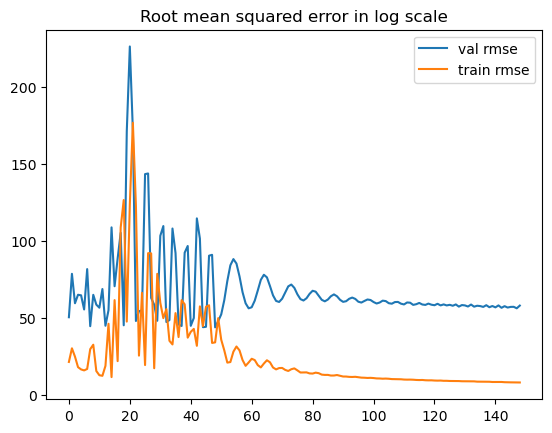

In [51]:
rmse2 = np.sqrt(model2.evaluate(np.array(x_test2), y_test)[2])
print(f"rmse2: {rmse2}")

plotHistoryRSME(history2)

#### [Model3] Fix
It's weird to have higher error with more data. Let's try normalize BTC price first.

In [24]:
print(f"x_train mean: {np.mean(x_train)}")
print(f"x_train_btc mean: {np.mean(x_train_btc)}")
np.mean(x_train_btc) / np.mean(x_train)

x_train mean: 292.94542302357837
x_train_btc mean: 26216.23616504854


89.49187836581584

BTC is about 90 times higher than BNB. Let's scale it down by 90.

In [25]:
BTC_FOR_BNB_SCALE = 90

# x_train = prepareTrainingInputs(bnb_data["Close"], windowSize, testSize)
x_train_btc = prepareTrainingInputs(btc_data["Close"], windowSize, testSize) / BTC_FOR_BNB_SCALE
x_train3 = [np.concatenate((x_train[i], x_train_btc[i])) for i in range(len(x_train))]
# y_train = prepareTraingingOutputs(bnb_data["Close"], windowSize, testSize)

# x_test = prepareTestingInputs(bnb_data["Close"], windowSize, testSize)
x_test_btc = prepareTestingInputs(btc_data["Close"], windowSize, testSize) / BTC_FOR_BNB_SCALE
x_test3 = [np.concatenate((x_test[i], x_test_btc[i])) for i in range(len(x_test))]
# y_test = prepareTestingOutputs(bnb_data["Close"], testSize)

train_features_dataset = tf.data.Dataset.from_tensor_slices(x_train3)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)
test_features_dataset = tf.data.Dataset.from_tensor_slices(x_test3)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
train_dataset, test_dataset

nbeatNeuronCount = 512
nBeatLayerCount = 4
nBeatStackCount = 30

# Create input to stacks
input = layers.Input(shape=(windowSize*2), name="stack_input")
x = input
x = buildNBeatLayers(windowSize*2, windowSize*2+1, 1, nbeatNeuronCount, nBeatLayerCount, nBeatStackCount, x)

model3 = tf.keras.Model(inputs=input, outputs=x)
# model3.summary()

model3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

history3 = model3.fit(train_dataset,
            epochs=5000, # just a large number
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 154: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 254: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


3/3 [==============================] - 2s 41ms/step - loss: 3.1211 - mae: 3.1211 - mse: 17.8653
rmse3: 4.226738945456309
RMSE: 4.90
epoch: 254


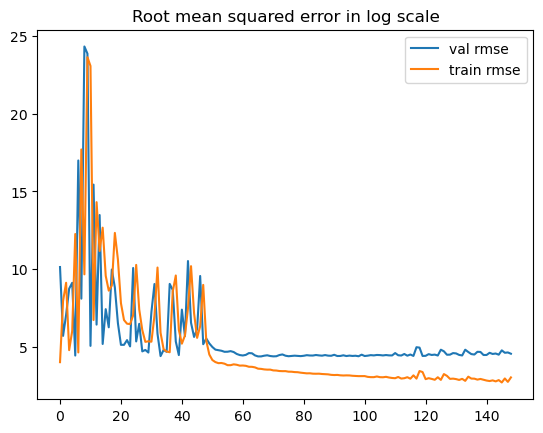

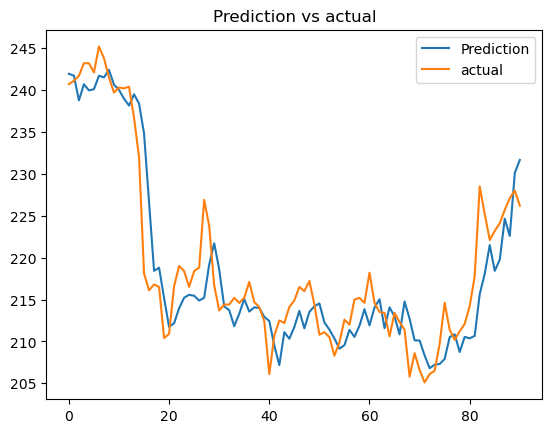

In [52]:
rmse3 = np.sqrt(model3.evaluate(np.array(x_test3), y_test)[2])
print(f"rmse3: {rmse3}")

plotHistoryRSME(history3)
plt.figure()

# plot prediction
prediction3 = model3.predict(np.array(x_test3))
plt.plot(prediction3, label='Prediction')
plt.plot(y_test, label='actual')
plt.title('Prediction vs actual')
plt.legend()

#### [Model4] Swap input position

Lets try putting BTC values before BNB values.

In [28]:
BTC_FOR_BNB_SCALE = 90

# x_train = prepareTrainingInputs(bnb_data["Close"], windowSize, testSize)
# x_train_btc = prepareTrainingInputs(btc_data["Close"], windowSize, testSize) / BTC_FOR_BNB_SCALE
x_train4 = [np.concatenate((x_train_btc[i], x_train[i])) for i in range(len(x_train))]
# y_train = prepareTraingingOutputs(bnb_data["Close"], windowSize, testSize)

# x_test = prepareTestingInputs(bnb_data["Close"], windowSize, testSize)
# x_test_btc = prepareTestingInputs(btc_data["Close"], windowSize, testSize) / BTC_FOR_BNB_SCALE
x_test4 = [np.concatenate((x_test_btc[i], x_test[i])) for i in range(len(x_test))]
# y_test = prepareTestingOutputs(bnb_data["Close"], testSize)

train_dataset, test_dataset = prepareDataSetFromArray(x_train4, y_train, x_test4, y_test)

In [29]:
nbeatNeuronCount = 512
nBeatLayerCount = 4
nBeatStackCount = 30

# Create input to stacks
input = layers.Input(shape=(windowSize*2), name="stack_input")
x = input
x = buildNBeatLayers(windowSize*2, windowSize*2+1, 1, nbeatNeuronCount, nBeatLayerCount, nBeatStackCount, x)

model4 = tf.keras.Model(inputs=input, outputs=x)
# model4.summary()

model4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

history4 = model4.fit(train_dataset,
            epochs=5000, # just a large number
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 223: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 323: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


3/3 [==============================] - 2s 42ms/step - loss: 3.0080 - mae: 3.0080 - mse: 17.7971
rmse4: 4.218665002037263
RMSE: 4.52
epoch: 323


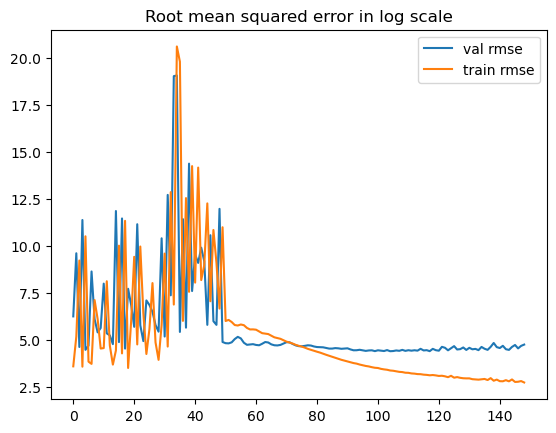

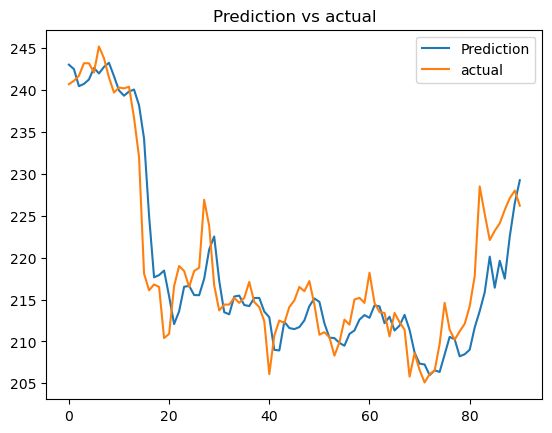

In [53]:
rmse4 = np.sqrt(model4.evaluate(np.array(x_test4), y_test)[2])
print(f"rmse4: {rmse4}")

# plot error
plotHistoryRSME(history4)
plt.figure()

# plot prediction
prediction4 = model4.predict(np.array(x_test4))
plt.plot(prediction4, label='Prediction')
plt.plot(y_test, label='actual')
plt.title('Prediction vs actual')
plt.legend()

#### [Model5] Increase Neuron

It seems that BTC data would confuse the model, or it doesn't have enough unit to process the data. Let's try to increase the neuron number.

In [31]:
print(f"windowSize {windowSize}")
print(f"x_train4 {np.array(x_train4).shape}")

windowSize 7
x_train4 (206, 14)


In [32]:
np.array(y_train).shape

(206,)

In [33]:
# BTC_FOR_BNB_SCALE = 90

# x_train = prepareTrainingInputs(bnb_data["Close"], windowSize, testSize)
# x_train_btc = prepareTrainingInputs(btc_data["Close"], windowSize, testSize) / BTC_FOR_BNB_SCALE
# x_train4 = [np.concatenate((x_train_btc[i], x_train[i])) for i in range(len(x_train))]
# y_train = prepareTraingingOutputs(bnb_data["Close"], windowSize, testSize)

# x_test = prepareTestingInputs(bnb_data["Close"], windowSize, testSize)
# x_test_btc = prepareTestingInputs(btc_data["Close"], windowSize, testSize) / BTC_FOR_BNB_SCALE
# x_test4 = [np.concatenate((x_test_btc[i], x_test[i])) for i in range(len(x_test))]
# y_test = prepareTestingOutputs(bnb_data["Close"], testSize)

train_dataset, test_dataset = prepareDataSetFromArray(x_train4, y_train, x_test4, y_test)

nbeatNeuronCount = 512
# nbeatNeuronCount = round(512 * np.power(2, 0.5)) # the number of attributes should be increased by 2
nBeatLayerCount = 4
nBeatStackCount = 30

# Create input to stacks
input = layers.Input(shape=(windowSize*2), name="stack_input")
x = input
x = buildNBeatLayers(windowSize*2, windowSize*2+1, 1, nbeatNeuronCount, nBeatLayerCount, nBeatStackCount, x)

model5 = tf.keras.Model(inputs=input, outputs=x)
model5.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 stack_input (InputLayer)       [(None, 14)]         0           []                               
                                                                                                  
 InitialBlock (NBeatsBlock)     ((None, 14),         803343      ['stack_input[0][0]']            
                                 (None, 1))                                                       
                                                                                                  
 nbeat_subtract_00 (Subtract)   (None, 14)           0           ['stack_input[0][0]',            
                                                                  'InitialBlock[0][0]']           
                                                                                            

In [34]:
model5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

history5 = model5.fit(train_dataset,
            epochs=5000, # just a large number
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 135: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 235: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


3/3 [==============================] - 2s 40ms/step - loss: 3.3619 - mae: 3.3619 - mse: 19.7735
rmse5: 4.44674536166885
RMSE: 5.67
epoch: 235


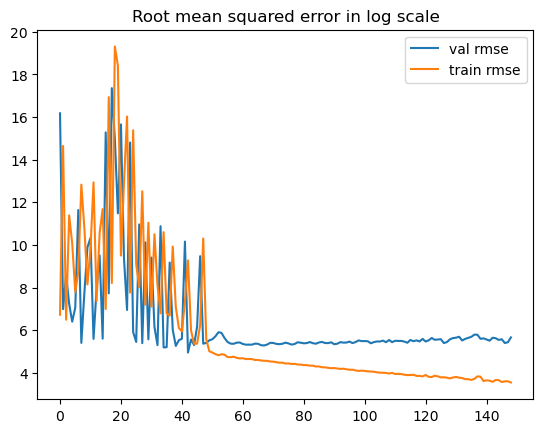

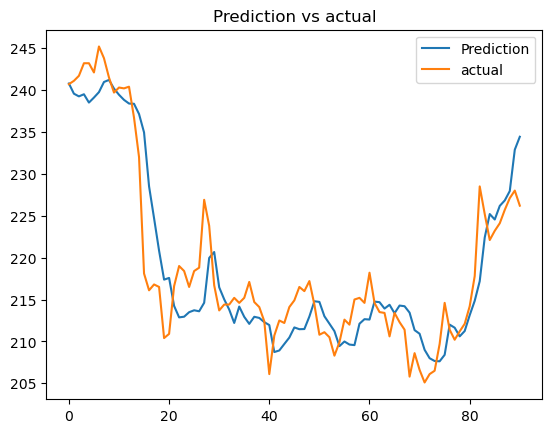

In [54]:
rmse5 = np.sqrt(model5.evaluate(np.array(x_test4), y_test)[2])
print(f"rmse5: {rmse5}")

# plot error
plotHistoryRSME(history5)
plt.figure()

# plot prediction
prediction5 = model5.predict(np.array(x_test4))
plt.plot(prediction5, label='Prediction')
plt.plot(y_test, label='actual')
plt.title('Prediction vs actual')
plt.legend()

#### Conclusion

The model with BTC data seems performs worse that without it. Lets try with more data and larger window size next time.

<BarContainer object of 5 artists>

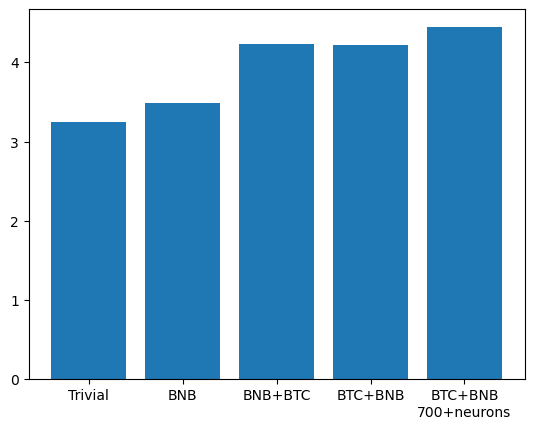

In [58]:
models = ["Trivial", "BNB", "BNB+BTC", "BTC+BNB", "BTC+BNB\n700+neurons"]
rmses = [rmse0, rmse1, rmse3, rmse4, rmse5]
plt.bar(models, rmses)